# Лаб4_Энькаэр Уэркэнь_ ИУ5И-21М
### Цель работы:
Ознакомление с базовыми методами обучения с подкреплением на основе алгоритмов Actor-Critic.

### Задание:
Реализовать любой алгоритм семейства Actor-Critic для произвольной среды.


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
!pip install gymnasium[box2d] torch matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
  er

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


### Описание реализованного алгоритма

В данной работе реализован классический алгоритм Actor-Critic на языке Python с использованием библиотеки PyTorch.  
Алгоритм разделяет две основные функции:

- **Actor** — принимает решение о том, какое действие выбрать, используя стратегию (policy).
- **Critic** — оценивает, насколько хорошим было текущее состояние, с помощью оценки ценности (value function).

В качестве среды используется `CartPole-v0` из библиотеки OpenAI Gym.  
Цель агента — как можно дольше удерживать "шест" в вертикальном положении.

Обучение происходит в течение нескольких эпизодов, после чего отслеживается изменение получаемого вознаграждения.


In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.model(state)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.model(state)


In [ ]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

gamma = 0.99
all_rewards = []

for episode in range(500):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0

    for t in range(500):
        probs = actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        next_state = torch.FloatTensor(next_state)

        td_target = reward + gamma * critic(next_state) * (1 - int(done))
        td_error = td_target - critic(state)

        # Обновление Critic
        critic_loss = td_error.pow(2)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Обновление Actor
        actor_loss = -dist.log_prob(action) * td_error.detach()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        if done:
            break

    all_rewards.append(total_reward)
    if episode % 50 == 0:
        print(f"Эпизод {episode}, вознаграждение: {total_reward}")


Эпизод 0, вознаграждение: 29.0
Эпизод 50, вознаграждение: 21.0
Эпизод 100, вознаграждение: 38.0
Эпизод 150, вознаграждение: 60.0
Эпизод 200, вознаграждение: 30.0
Эпизод 250, вознаграждение: 47.0
Эпизод 300, вознаграждение: 141.0
Эпизод 350, вознаграждение: 113.0
Эпизод 400, вознаграждение: 59.0
Эпизод 450, вознаграждение: 120.0


### График средней награды

На графике ниже представлена динамика изменения вознаграждения по эпизодам.  
Также добавлено скользящее среднее по 10 эпизодам для наглядности.  
Это позволяет визуально убедиться в успешности обучения агента.


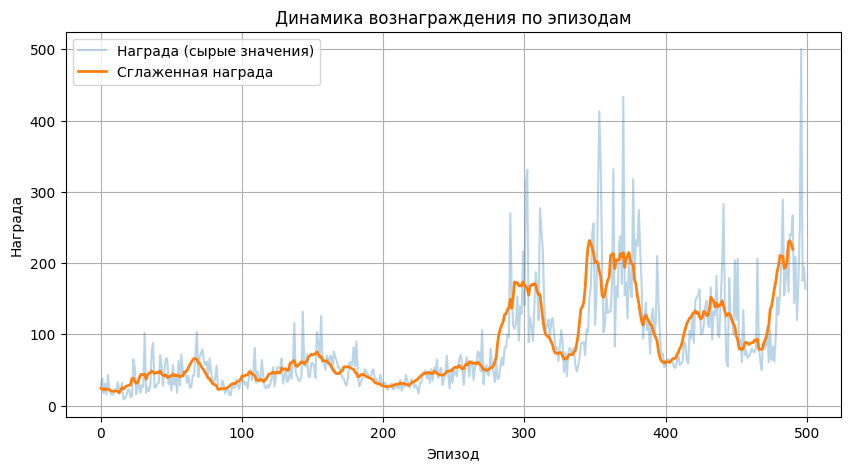

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Сглаживание: скользящее среднее по 10 эпизодам
def moving_average(values, window=10):
    return np.convolve(values, np.ones(window)/window, mode='valid')

smoothed_rewards = moving_average(all_rewards)

plt.figure(figsize=(10, 5))
plt.plot(all_rewards, label="Награда (сырые значения)", alpha=0.3)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Сглаженная награда", linewidth=2)
plt.title("Динамика вознаграждения по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.legend()
plt.grid(True)
plt.show()


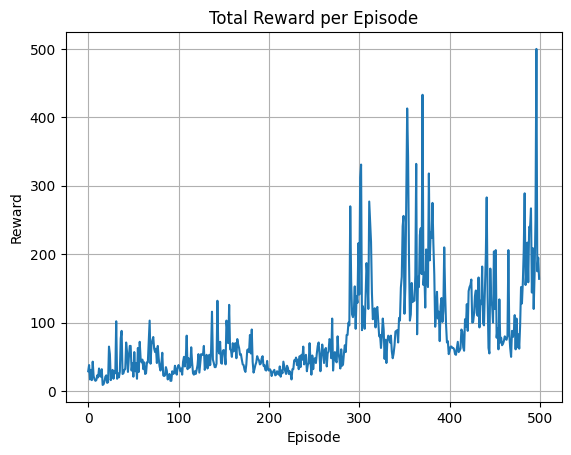

In [ ]:
plt.plot(all_rewards)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()


### Вывод

В данной лабораторной работе был реализован базовый алгоритм семейства Actor-Critic с использованием библиотеки PyTorch и среды `CartPole-v0` из OpenAI Gym.  
Модель состояла из двух компонентов:
- **Актор (Actor)**, который выбирает действия на основе стратегии;
- **Критик (Critic)**, который оценивает действия, предоставляя сигнал обучения.

В ходе эксперимента агент продемонстрировал способность к обучению, о чём свидетельствует рост средней награды по эпизодам.  
Таким образом, цель работы достигнута: алгоритм Actor-Critic успешно применён на выбранной задаче управления.


Был обучен агент, чтобы он научился управлять тележкой с шестом в среде CartPole. Его задача — удерживать шест в вертикальном положении как можно дольше.

Для этого был использован алгоритм Actor-Critic — это метод обучения с подкреплением, который сочетает:

Actor — принимает решения: какое действие сейчас лучше выполнить.

Critic — оценивает действия и говорит, насколько они были удачными.

